<a href="https://colab.research.google.com/github/AmonTonui/Final_Year_Project/blob/main/TuningSigma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  # Install Intrasom
  !pip install minisom

LOCAL_DEV = True
if LOCAL_DEV:
    sys.path.insert(0, '../')
    %load_ext autoreload



  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=0be7886eef41ee8054c91b2acf9d697f0c999f836ba16b4d331d9acf2f06e29c
  Stored in directory: /root/.cache/pip/wheels/19/db/95/5e53bc2b88a328217fdf9f2886cafbe86b0df274f4b601f572
Successfully built minisom


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from minisom import MiniSom
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import numpy as np
from sklearn.model_selection import train_test_split


data = pd.read_csv("mergednormalized_with_winners_cleaned2024.csv")

filtered_data = data[data['Winning Party'].isin(['Labour', 'Conservative', 'Liberal Democrat'])]

party_colors = {
    'Conservative': (0, 0, 1),    # Blue
    'Labour': (1, 0, 0),          # Red
    'Liberal Democrat': (1, 0.65, 0),  # Orange
    # 'Green': (0, 0.5, 0),         # Dark Green
    # 'The Brexit Party': (0.8, 0.4, 0), #light blue
    # 'Reform UK': (0, 0, 0.5), # Dark Blue

}


#Data with Labels that I will use to map the result clusters
labeling_columns = ['Westminster Parliamentary constituencies', 'Winning Party', 'Winning Vote Share']
features = filtered_data.drop(columns=labeling_columns)

#Feature Scaling
# scaler = MinMaxScaler()
# normalized_features = scaler.fit_transform(data[features])

robust_scaler = RobustScaler()
normalized_features = robust_scaler.fit_transform(features)


#Spliting the data in to training, validation and test
train_data, validation_data = train_test_split(normalized_features, test_size=0.3, random_state=42)
# validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)



print(f"Training set: {train_data.shape}")
print(f"Validation set: {validation_data.shape}")
# print(f"Test set: {test_data.shape}")

# normalized_df = pd.DataFrame(normalized_features, columns=features.columns)
# normalized_df[labeling_columns] = data[labeling_columns]

# print(normalized_df.head())

Training set: (254, 24)
Validation set: (109, 24)


In [3]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import numpy as np
n_neurons = int(np.sqrt(5 * np.sqrt(normalized_features.shape[0])))
space = {
    'sigma': hp.uniform('sigma', 0.001, n_neurons / 2.01),  # Sigma range
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.5)  # Learning rate range

}

In [5]:
# from hyperopt import STATUS_OK
from minisom import MiniSom

def som_objective(params):
    # hyperparameters being optimized
    sigma = params['sigma']
    learning_rate = params['learning_rate']


    # Initialize SOM
    som = MiniSom(n_neurons, n_neurons, train_data.shape[1], sigma=sigma, learning_rate=learning_rate)

    # Train SOM
    som.train_random(train_data, 3500)

    # Compute quantization error
    quantization_error = som.quantization_error(train_data)
    validation_error = som.quantization_error(validation_data)

    return {'loss': validation_error, 'status': STATUS_OK, 'quantization_error': quantization_error, 'validation_error': validation_error}

In [6]:
from hyperopt import fmin, tpe, Trials

#to track the trials
trials = Trials()

# Perform bayesian hyperparameter optimization of the objective function:Som_objective above
best_params = fmin(
    fn=som_objective,  # Objective function
    space=space,
    algo=tpe.suggest,
    max_evals=400,     # Number of evaluations
    trials=trials
)

print("Best Hyperparameters:", best_params)

100%|██████████| 400/400 [01:31<00:00,  4.38trial/s, best loss: 1.4173711979291173]
Best Hyperparameters: {'learning_rate': np.float64(0.36196177195589485), 'sigma': np.float64(1.251550438043095)}


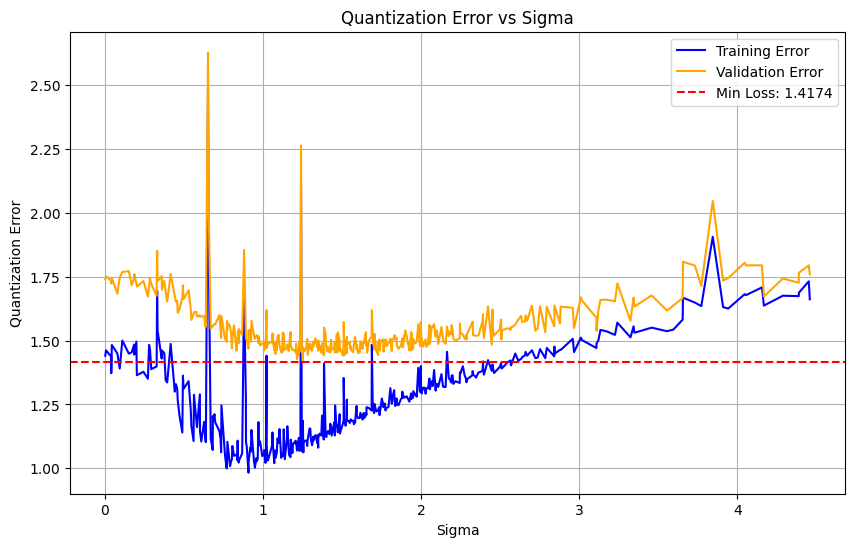

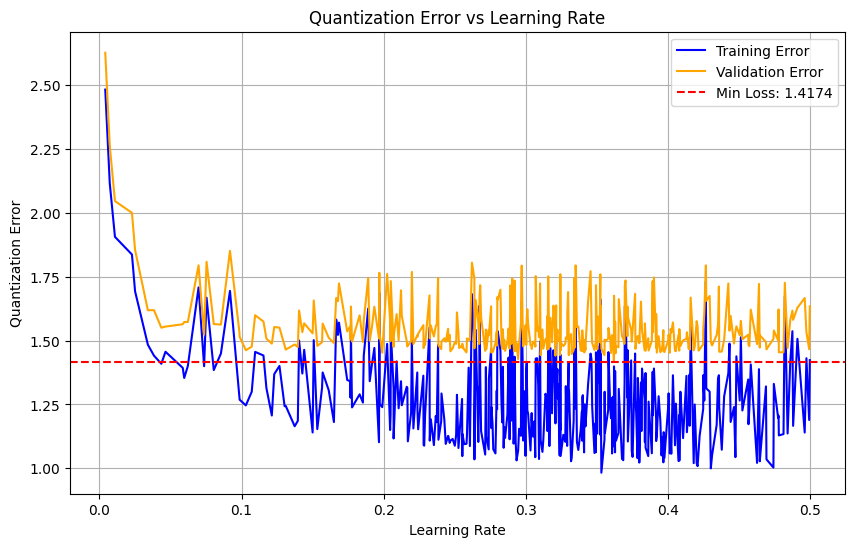

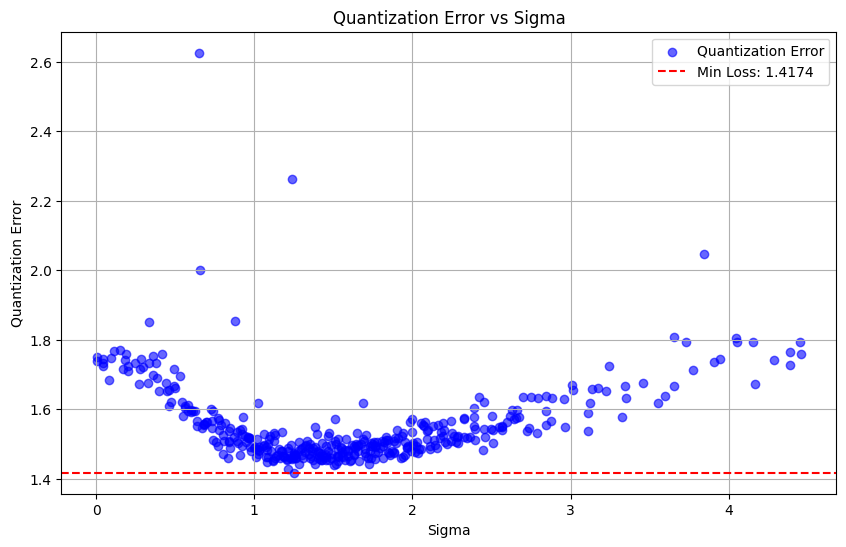

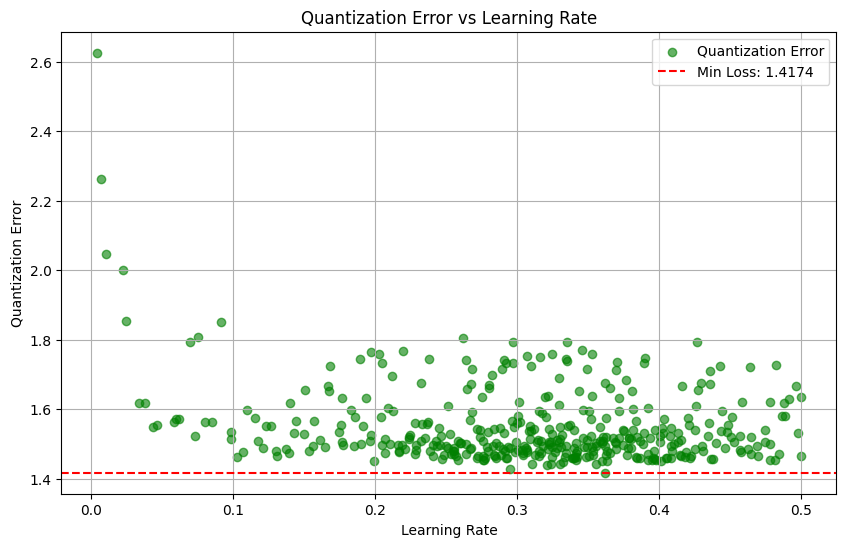

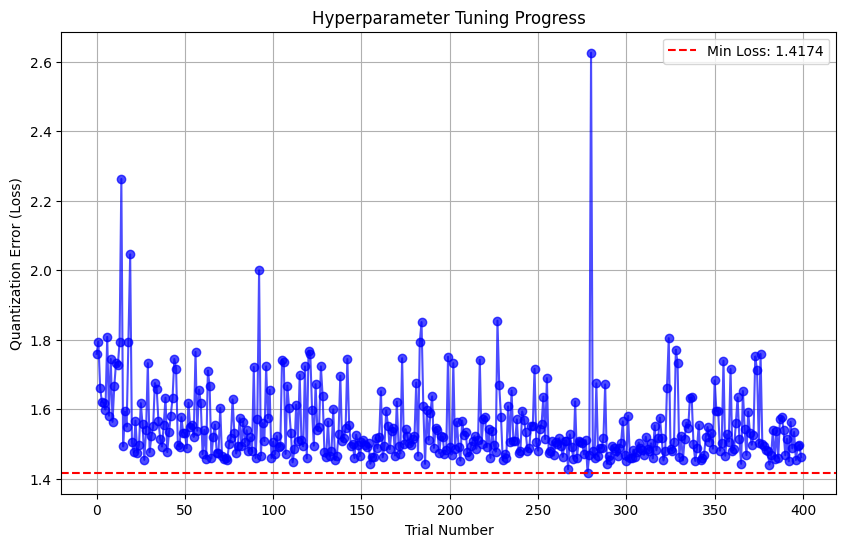

In [15]:
sigmas = [trial['misc']['vals']['sigma'][0] for trial in trials.trials]
learning_rates = [trial['misc']['vals']['learning_rate'][0] for trial in trials.trials]
losses = [trial['result']['loss'] for trial in trials.trials]

validation_errors = [trial['result']['validation_error'] for trial in trials.trials]
train_errors = [trial['result']['quantization_error'] for trial in trials.trials]

# Sort values for to see where it plateaus
sorted_indices_sigma = np.argsort(sigmas)
sorted_sigmas = np.array(sigmas)[sorted_indices_sigma]
sorted_train_errors_sigma = np.array(train_errors)[sorted_indices_sigma]
sorted_validation_errors_sigma = np.array(validation_errors)[sorted_indices_sigma]

sorted_indices_lr = np.argsort(learning_rates)
sorted_learning_rates = np.array(learning_rates)[sorted_indices_lr]
sorted_train_errors_lr = np.array(train_errors)[sorted_indices_lr]
sorted_validation_errors_lr = np.array(validation_errors)[sorted_indices_lr]


#Quantization Error vs Sigma
plt.figure(figsize=(10, 6))
plt.plot(sorted_sigmas, sorted_train_errors_sigma, label='Training Error', color='blue')
plt.plot(sorted_sigmas, sorted_validation_errors_sigma, label='Validation Error', color='orange')
plt.title("Quantization Error vs Sigma")
plt.xlabel("Sigma")
plt.ylabel("Quantization Error")
plt.axhline(y=min(losses), color='red', linestyle='--', label=f"Min Loss: {min(losses):.4f}")
plt.legend()
plt.grid()
plt.show()

# Plot Quantization Error vs Learning Rate
plt.figure(figsize=(10, 6))
plt.plot(sorted_learning_rates, sorted_train_errors_lr, label='Training Error', color='blue')
plt.plot(sorted_learning_rates, sorted_validation_errors_lr, label='Validation Error', color='orange')
plt.title("Quantization Error vs Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("Quantization Error")
plt.axhline(y=min(losses), color='red', linestyle='--', label=f"Min Loss: {min(losses):.4f}")
plt.legend()
plt.grid()
plt.show()


# Plot quantization error vs sigma
plt.figure(figsize=(10, 6))
plt.scatter(sigmas, losses, c='blue', alpha=0.6, label='Quantization Error')
plt.title("Quantization Error vs Sigma")
plt.xlabel("Sigma")
plt.ylabel("Quantization Error")
plt.axhline(y=min(losses), color='red', linestyle='--', label=f"Min Loss: {min(losses):.4f}")
plt.legend()
plt.grid()
plt.show()

# Plot quantization error vs learning rate
plt.figure(figsize=(10, 6))
plt.scatter(learning_rates, losses, c='green', alpha=0.6, label='Quantization Error')
plt.title("Quantization Error vs Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("Quantization Error")
plt.axhline(y=min(losses), color='red', linestyle='--', label=f"Min Loss: {min(losses):.4f}")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(len(losses)), losses, marker='o', linestyle='-', color='b', alpha=0.7)
plt.title("Hyperparameter Tuning Progress")
plt.xlabel("Trial Number")
plt.ylabel("Quantization Error (Loss)")
plt.axhline(y=min(losses), color='r', linestyle='--', label=f"Min Loss: {min(losses):.4f}")
plt.legend()
plt.grid()
plt.show()